                                Climate Investigation   SMU 2019 Data Science :  Ming Gao 

# Dependencies setup

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import datetime as dt
from scipy.stats import ttest_rel
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Connect to Hawaii sqlite DB and creat session link from python to DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [3]:
# Check Class (Measurement) column names
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__ 

# Query the date of the last day in the dataset (output:('2017-08-23'))
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Retrieve the last 12 months of precipitation data (date and prcp values)
results=session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date <'2017-08-24').\
                    filter(Measurement.date > '2016-08-22').all() 

# Create a dataframe(set date column as the index, drop null values, sort dataframe vaules by date)
df_prcp=pd.DataFrame(results,columns=["Date", "Precipitation"])
df_prcp_index=df_prcp.set_index("Date")
df_prcp_new=df_prcp_index.dropna().sort_index()
df_prcp_new.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


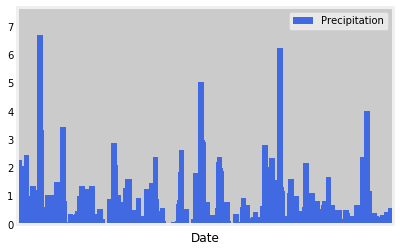

In [4]:
# Plot the precipation result: bar chart
x_value=np.arange(len(df_prcp_new.index))
y_value=df_prcp_new['Precipitation'].tolist()

fig, ax = plt.subplots()
bar_width = 30
opacity = 1

plot = plt.bar(x_value, y_value, bar_width, align="center", alpha=opacity, color='royalblue', label='Precipitation')

ax.set_ylim(0, max(y_value)+1)
ax.set_xlim(0, len(df_prcp_new.index)+1)
ax.grid(True)

plt.xlabel('Date')
plt.ylabel('')
plt.title('')
plt.xticks(x_value,'')
plt.legend()

plt.show()

In [5]:
# Calcualte the summary statistics for the precipitation data
df_prcp_new[["Precipitation"]].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [6]:
# Check Class (Station) column names
first_row_station = session.query(Station).first()
first_row_station.__dict__

# Query the total number of distinct stations in this dataset  (output:9)
session.query(Measurement.station).distinct().count()

# Query station numbers by count and list them in decending order
session.query(Measurement.station,\
              func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [7]:
# Query the most active station
session.query(Measurement.station,\
              func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()[0]

('USC00519281', 2772)

In [8]:
# Calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
session.query(Measurement.station,\
              func.min(Measurement.tobs),\
              func.max(Measurement.tobs),\
              func.avg(Measurement.tobs))\
             .group_by(Measurement.station).\
              order_by(func.count(Measurement.station).desc()).all()[0]

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [9]:
# Choose the station with the highest number of temperature observations (=USC00519281)
# Query the last 12 months of temperature observation data for this station
temps=session.query(Measurement.date,Measurement.tobs).\
                filter(Measurement.date <'2017-08-24').\
                filter(Measurement.date > '2016-08-22').\
                filter(Measurement.station=="USC00519281").all()

# Creat a datafrme to hold all values (set date column as the index, drop null values, sort dataframe vaules by date)
df_temp = pd.DataFrame(temps, columns=['Date', 'Temperature'])
df_temp_index=df_temp.set_index("Date")
df_temp_new=df_temp_index.dropna().sort_index()
df_temp_new.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


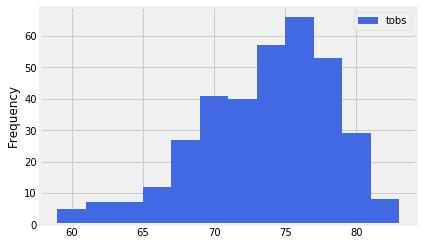

In [10]:
# Plot the results as a histogram, bin=12
x_value=np.arange(len(df_temp_new.index))
y_value=df_temp_new['Temperature'].tolist()

plot=df_temp_new.hist(column='Temperature', bins=12, grid=True, figsize=(6,4),\
                   color='royalblue', rwidth=1, label="tobs")
plt.legend()
plt.ylabel('Frequency')
plt.title('')
plt.show()

## Optional Challenge Assignment

### Temperature Analysis I

In [11]:
# Query the average temperature in June at all stations across all available years in the dataset
June_data=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").\
group_by(Measurement.station).all()
# unpack tuple to list
June_data=list(np.ravel(June_data))

# Query the average temperature in December at all stations across all available years in the dataset
December_data=session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").\
group_by(Measurement.station).all()
# unpack tuple to list
December_data=list(np.ravel(December_data))

In [12]:
# Paried t-test between June data and December data (P value=0.0001179, is highly statistically significant)
ttest_rel(June_data,December_data)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

### Temperature Analysis II

In [13]:
# Create a function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d        
    Returns:
        TMIN, TAVE, and TMAX
    """ 
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [14]:
# Choose trip dates (7 days)
start_day=str('2017-08-13')
end_day=str('2017-08-19')

# Use function `calc_temps` to calculate the tmin, tavg, and tmax using the previous year's data for those same dates.
trip_date=calc_temps(start_day,end_day)
# unpack tuple to list
trip_data=list(np.ravel(trip_date))

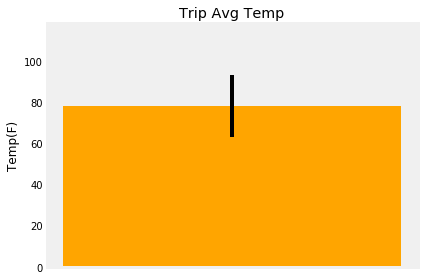

In [23]:
# Plot the result with errot bar
y_value=trip_data[1]
yerr_value=trip_data[2]-trip_data[0]

fig, ax = plt.subplots()
plot = plt.bar(x="",height=y_value, yerr=yerr_value,color='orange',width = 1)
ax.set_ylim(0, y_value+40)
ax.grid(False)

plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
fig.tight_layout()
plt.show()

### Daily Rainfall Average

In [16]:
# Calculate the total amount of rainfall per weather station for the trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station,func.sum(Measurement.prcp),\
              Station.name,Station.latitude, Station.longitude, Station.elevation).\
                filter(Measurement.station==Station.station).\
                filter(Measurement.date <=end_day).\
                filter(Measurement.date >= start_day).group_by(Measurement.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  1.28,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.51,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  0.26,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  0.01,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.    
    Args:
        date (str): A date string in the format '%m-%d'        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [18]:
# Generate normals list to hold tmin, tmax, and tavg values in selected days by looping trip dates
trip_dates=["08-13","08-14","08-15","08-16","08-17","08-18","08-19"]

normals=[]

for date in trip_dates:
    normal=list(np.ravel(daily_normals(date)))
    normals.append(normal)
    
print(normals)

[[71.0, 76.98245614035088, 84.0], [71.0, 76.77777777777777, 82.0], [69.0, 76.47169811320755, 83.0], [69.0, 76.08, 83.0], [69.0, 76.125, 83.0], [70.0, 76.92307692307692, 84.0], [69.0, 75.94642857142857, 85.0]]


In [19]:
# Loop through the normals list 
# Calculate the normals for each date, then append avg, max and min values into each catagory list(avg_tobs,max_tobs,min_tobs)
avg_tobs=[]
max_tobs=[]
min_tobs=[]
    
for x in range(len(normals)):
    avg_tobs.append(normals[x][0])
    max_tobs.append(normals[x][1])
    min_tobs.append(normals[x][2])

print(avg_tobs)  
print(max_tobs)
print(min_tobs)

[71.0, 71.0, 69.0, 69.0, 69.0, 70.0, 69.0]
[76.98245614035088, 76.77777777777777, 76.47169811320755, 76.08, 76.125, 76.92307692307692, 75.94642857142857]
[84.0, 82.0, 83.0, 83.0, 83.0, 84.0, 85.0]


In [20]:
# Load the query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df=pd.DataFrame(zip(trip_dates,avg_tobs,max_tobs,min_tobs),columns=['Trip Date','Min Temp','Avg Temp','Max Temp'])
trip_df.head()

,Trip Date,Min Temp,Avg Temp,Max Temp
0,08-13,71.0,76.982456,84.0
1,08-14,71.0,76.777778,82.0
2,08-15,69.0,76.471698,83.0
3,08-16,69.0,76.080000,83.0
4,08-17,69.0,76.125000,83.0


([<matplotlib.axis.XTick at 0x1fa139cbac8>,
 <a list of 7 Text xticklabel objects>)

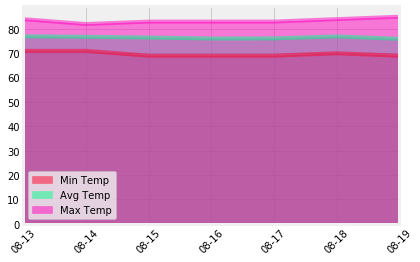

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
from matplotlib import cm
x=np.arange(len(trip_df.index))
cmap=cm.get_cmap('gist_rainbow')

trip_df.plot.area(stacked=False,colormap=cmap)
plt.xticks(x,trip_df['Trip Date'],rotation=45)